In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from kornia.filters import SpatialGradient
from collections import OrderedDict

In [2]:
# # # Dataloader
class dataset(Dataset):
    def __init__(self, dir_path, csv_file):
        super(Dataset, self).__init__()

        self.dir_path = dir_path
        self.csv_file = pd.read_csv(csv_file,index_col=0)

        self.output = self.csv_file['y_number']

        self.transform = transforms.Compose([
    transforms.ToTensor()
])

    def __len__(self):
        return self.csv_file.shape[0]
        
    def __getitem__(self, index):

        # Get the indice for the output wavefield
        self.output_im = self.output.astype(int)[index]

        inputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in range(self.output_im-4,self.output_im)]
        #print(list(im for im in range(self.output_im-4,self.output_im))) # For debugging

        outputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in [self.output_im]]
        #print(list(im for im in [self.output_im])) # For debugging

        inputs = self.transform(np.array(inputs))
        outputs = self.transform(np.array(outputs))
        sample = {"wave_input": inputs,
                    "wave_input_label":self.output_im,
                    "wave_output": outputs,
                    "wave_output_label":self.output_im}
        return sample

In [3]:
training_data = dataset('Simple_Homogeneous_Moseley/','Simple_Homogeneous_Moseley_Event0000_Continuous.csv')

Text(0.5, 1.0, 'Output - Wavefield 10')

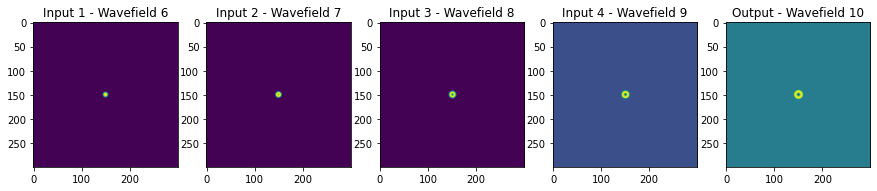

In [14]:
sample = training_data.__getitem__(0)

x_4 = sample['wave_input'].transpose(1, 0)[:,::4,::4]
x_2 = sample['wave_input'].transpose(1, 0)[:,::2,::2]
x_1 = sample['wave_input'].transpose(1, 0)

gt = sample['wave_output'].transpose(1, 0)[None]

# # # Plot
fig, axs = plt.subplots(1,5,figsize=(15,3))

axs = axs.ravel()
for _i, ax in enumerate(axs[:-1]):
    ax.imshow(sample['wave_input'].transpose(1, 0).detach().numpy()[_i,:,:])

    wavefield = sample['wave_output_label'] - 4 + _i

    ax.set_title(f'Input {_i+1} - Wavefield {wavefield}')

axs[-1].imshow(sample['wave_output'].transpose(1, 0).detach().numpy()[0,:,:])
axs[-1].set_title('Output - Wavefield {}'.format(sample['wave_output_label']))

In [31]:
dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

In [40]:
class AutoEncoder(nn.Module):

    def __init__(self, in_channels=4, out_channels=1, init_features=32):
        super(AutoEncoder, self).__init__()

        ###################
        # # # Encoder # # #
        ###################

        features = init_features
        self.encoder1 = AutoEncoder._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = AutoEncoder._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = AutoEncoder._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = AutoEncoder._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = AutoEncoder._block(features * 8, features * 16, name="bottleneck")

        ###################
        # # # Decoder # # #
        ###################

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2, output_padding = 1 # Add output_padding to match that 37 is not divisible by 2 in the encoder
        )
        self.decoder4 = AutoEncoder._block(features * 8, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2, output_padding = 1 # Add output_padding to match that 75 is not divisible by 2 in the encoder
        )
        self.decoder3 = AutoEncoder._block(features * 4, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = AutoEncoder._block(features * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = AutoEncoder._block(features, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):

        ###################
        # # # Encoder # # #
        ###################

        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        ###################
        # # # Decoder # # #
        ###################

        dec4 = self.upconv4(bottleneck)
        dec3 = self.upconv3(self.decoder4(dec4))
        dec2 = self.upconv2(self.decoder3(dec3))
        dec1 = self.upconv1(self.decoder2(dec2))
        dec1 = self.decoder1(dec1)

        return self.conv(dec1) # No activation function because we want to return the real value, not a prediction between 0 and 1 if the sigmoid was used

    @staticmethod # Static method to define each block in the AutoEncoder
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [41]:
class GDLLoss(nn.Module):
    def __init__(self,alpha=2): 
        super(GDLLoss, self).__init__()

        self.grad = SpatialGradient(normalized=True)
        self.alpha = alpha

    def forward(self,gen,gt,alpha=2):

        self.gen_dx = self.grad(gen)[:,:,0,:,:]
        self.gen_dy = self.grad(gen)[:,:,1,:,:]
        self.gt_dx = self.grad(gt)[:,:,0,:,:]
        self.gt_dy = self.grad(gt)[:,:,1,:,:]

        self.grad_diff_x = torch.abs(self.gt_dx - self.gen_dx)
        self.grad_diff_y = torch.abs(self.gt_dy - self.gen_dy)

        return torch.mean(self.grad_diff_x ** self.alpha + self.grad_diff_y ** self.alpha)

In [42]:
class MSLoss(nn.Module):
    def __init__(self): 
        super(MSLoss, self).__init__()

        self.gdl_fn = GDLLoss()
        self.mse_fn = nn.MSELoss()

    def forward(self,gen,gt):

        # Loss function  : L_2 (preds-true) + L_GDL (preds-true) + L_G (TODO)
        
        loss_l2 = self.mse_fn(gen,gt)
        loss_gdl = self.gdl_fn(gen,gt)

        loss = loss_l2 + loss_gdl

        return loss, loss_l2, loss_gdl

In [43]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [45]:
dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

model = AutoEncoder(in_channels=4,out_channels=1)
model = model.to(device)

criterion = MSLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
epochs = 10

for epoch in range(epochs):
    
    train_loss = 0
    train_loss_l2 = 0
    train_loss_gdl = 0

    model.train()

    for samples in dataloader:

        wave_input = samples['wave_input'].transpose(2, 1)
        wave_input = wave_input.to(device)
        wave_input.require_grad = True
 
        gt = samples['wave_output'].transpose(2, 1)
        gt = gt.to(device)

        optimizer.zero_grad()

        gen = model(wave_input)

        loss, loss_l2, loss_gdl = criterion(gen, gt)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * samples['wave_input'].size(0)
        train_loss_l2 += loss_l2.item() * samples['wave_input'].size(0)
        train_loss_gdl += loss_gdl.item() * samples['wave_input'].size(0)

    epoch_loss = train_loss / training_data.__len__()
    epoch_loss_l2 = train_loss_l2 / training_data.__len__()
    epoch_loss_gdl = train_loss_gdl / training_data.__len__()

    # Save best model, save loss
    
    print('Epoch : %d, Loss : %.5e, Loss L2: %.5e, Loss GDL: %.5e' % (epoch,epoch_loss,epoch_loss_l2,epoch_loss_gdl))

Epoch : 0, Loss : 2.10279e+01, Loss L2: 1.90116e+01, Loss GDL: 2.01628e+00
Epoch : 1, Loss : 9.15933e+00, Loss L2: 8.02676e+00, Loss GDL: 1.13257e+00
Epoch : 2, Loss : 4.13548e+00, Loss L2: 3.46108e+00, Loss GDL: 6.74403e-01
Epoch : 3, Loss : 2.63534e+00, Loss L2: 2.15159e+00, Loss GDL: 4.83752e-01
Epoch : 4, Loss : 2.26768e+00, Loss L2: 1.84079e+00, Loss GDL: 4.26886e-01
Epoch : 5, Loss : 1.89537e+00, Loss L2: 1.53499e+00, Loss GDL: 3.60380e-01
Epoch : 6, Loss : 1.43119e+00, Loss L2: 1.15205e+00, Loss GDL: 2.79142e-01
Epoch : 7, Loss : 1.18286e+00, Loss L2: 9.49997e-01, Loss GDL: 2.32859e-01
Epoch : 8, Loss : 1.39096e+00, Loss L2: 1.11043e+00, Loss GDL: 2.80535e-01
Epoch : 9, Loss : 1.09985e+00, Loss L2: 8.80304e-01, Loss GDL: 2.19547e-01


In [47]:
# # # Save model
dir_save = 'ENCODER_L2_GDL/'
model_name = f'L2_GDL_E{epochs}'

if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

PATH = dir_save + model_name + '.pt'
torch.save(model.state_dict(), PATH)

In [48]:
# # # Load model
epochs = 10
dir_save = 'ENCODER_L2_GDL/'
model_name = f'L2_GDL_E{epochs}'

PATH = dir_save + model_name + '.pt'

model_test = AutoEncoder(in_channels=4,out_channels=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

AutoEncoder(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [49]:
# # # Testing - One sample
time_step = 10

test_sample = training_data.__getitem__(time_step)

test_x = test_sample['wave_input'].transpose(1, 0)
test_x = test_x.to('cpu')
model = model_test.to('cpu')

test_gen = model(test_x[None])

test_gt = test_sample['wave_output'].transpose(1, 0)[None]

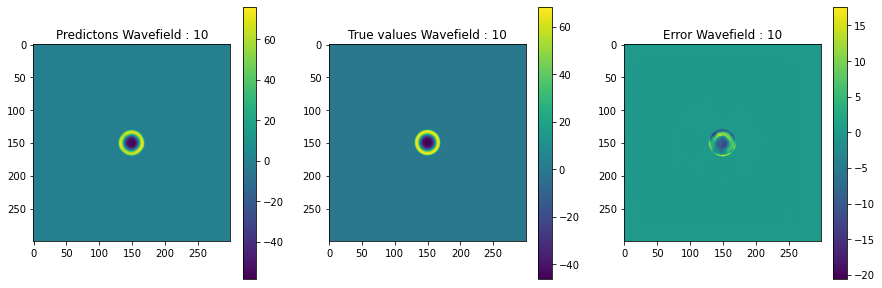

In [50]:
# # # Plot Testing - One Sample

pred = test_gen[0,0].detach().cpu().numpy()
true = test_gt[0,0].detach().cpu().numpy()
error = pred - true

fig , ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(pred)
ax[0].set_title(f'Predictons Wavefield : {time_step}')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(true)
ax[1].set_title(f'True values Wavefield : {time_step}')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(error)
ax[2].set_title(f'Error Wavefield : {time_step}')
plt.colorbar(im, ax=ax[2])